In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import os

# Function to fetch stock data from Yahoo Finance and save it to a CSV file
def fetch_data_and_save(symbol):
    try:
        # Fetch stock data
        stock = yf.Ticker(symbol)

        # Get historical data
        historical_data = stock.history(period="Max")

        # Save historical data to a CSV file
        historical_data.to_csv(f'/content/drive/MyDrive/stock_data/{symbol}_historical_data.csv', index=True)

        print(f"Data for {symbol} saved successfully.")
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {e}")

# Function to prepare data from a CSV file
def prepare_data(file_path):
    try:
        df = pd.read_csv(file_path)
        #deleting unneeded columns
        if 'Dividends' in df.columns and 'Stock Splits' in df.columns:
            del df['Dividends']
            del df['Stock Splits']
        else:
            print("Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.")
        #adding the Target column
        df['Tomorrow'] = df['Close'].shift(-1)
        df['Target'] = (df['Tomorrow'] > df['Close']).astype(int)
        return df.dropna()
    except Exception as e:
        print(f"Error occurred while preparing data: {e}")
        return pd.DataFrame()

# Function to prepare features for training
def prepare_features(df):
    horizons = [2, 5, 60, 250, 1000]
    for horizon in horizons:
        rolling_averages = df['Close'].rolling(horizon).mean()
        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df['Close'] / rolling_averages
        trend_column = f"Trend_{horizon}"
        df[trend_column] = df['Close'].shift(1).rolling(horizon).sum()
    return df.dropna()



# Function to train a machine learning model
def train_model(X_train, y_train, save_model=False, model_name=None):
    model = RandomForestClassifier(random_state=42)
    try:
        if len(X_train) > 0 and len(y_train) > 0:
            # Hyperparameter tuning using GridSearchCV
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
            grid_search.fit(X_train, y_train)
            best_params = grid_search.best_params_
            print(f"Best hyperparameters: {best_params}")

            # Train with best parameters
            model = RandomForestClassifier(**best_params, random_state=42)
            model.fit(X_train, y_train)

            # Save the model
            if save_model and model_name:
                model_path = f'/content/drive/MyDrive/prediction_models/{model_name}'
                joblib.dump(model, model_path)
                print(f"Model saved as {model_path}")

            return model
        else:
            print("Error: Empty dataframe or target variable. No data available for training.")
            return None
    except Exception as e:
        print(f"Error occurred while training model: {e}")
        return None




# Function to train models for all companies
def train_models():
    accuracy_dict = {}
    f1_scores = {}
    recall_scores = {}
    precision_scores = {}

    try:
        symbols_df = pd.read_csv("/content/drive/MyDrive/stock_data/tadawul_tickers.csv")
        symbols = symbols_df["Symbol.SA"].astype(str) + ".SR"
    except FileNotFoundError:
        print("Error: File 'tadawul_tickers.csv' not found.")
        return accuracy_dict, f1_scores, recall_scores, precision_scores
    except KeyError:
        print("Error: Column 'Symbol.SA' not found in the file.")
        return accuracy_dict, f1_scores, recall_scores, precision_scores

    for symbol in symbols:
        model_path = f"/content/drive/MyDrive/prediction_models/{symbol}_model.pkl"

        # Check if model already exists for this company
        if os.path.exists(model_path):
            print(f"Model already trained for {symbol}. Skipping training.")
            continue

        file_path = f"/content/drive/MyDrive/stock_data/{symbol}_historical_data.csv"
        fetch_data_and_save(symbol)
        df = prepare_data(file_path)

        if not df.empty:
            df = prepare_features(df)
            if not df.empty:
                predictors = ["Close", "Volume", "Open", "High", "Low"] + [f"Close_Ratio_{h}" for h in [2, 5, 60, 250, 1000]] + [f"Trend_{h}" for h in [2, 5, 60, 250, 1000]]
                X = df[predictors]
                y = df['Target']

                # Standardize features
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)

                # Handle class imbalance
                n_neighbors = min(5, sum(y == 1))  # Ensure neighbors don't exceed minority class size
                if n_neighbors <= len(X_scaled):
                    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
                    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

                    try:
                        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
                        model_name = f"{symbol}_model.pkl"
                        model = train_model(X_train, y_train, save_model=True, model_name=model_name)
                        if model:
                            y_pred = model.predict(X_test)
                            accuracy = accuracy_score(y_test, y_pred)
                            f1 = f1_score(y_test, y_pred)
                            recall = recall_score(y_test, y_pred)
                            precision = precision_score(y_test, y_pred)

                            accuracy_dict[symbol] = accuracy
                            f1_scores[symbol] = f1
                            recall_scores[symbol] = recall
                            precision_scores[symbol] = precision

                            print(f"Model trained successfully for {symbol}. Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}")

                    except ValueError as e:
                        print(f"Error occurred while splitting data for {symbol}: {e}. Skipping training and testing.")
                else:
                    print(f"Not enough samples in the minority class for {symbol}. Skipping SMOTE resampling.")
            else:
                print(f"No data available after feature engineering for {symbol}. Skipping training.")
        else:
            print(f"No data available for {symbol}. Skipping training.")

    return accuracy_dict, f1_scores, recall_scores, precision_scores



def print_metrics(accuracy_dict, f1_scores, recall_scores, precision_scores):
    # Calculate average values
    avg_accuracy = sum(accuracy_dict.values()) / len(accuracy_dict) if accuracy_dict else 0
    avg_f1 = sum(f1_scores.values()) / len(f1_scores) if f1_scores else 0
    avg_recall = sum(recall_scores.values()) / len(recall_scores) if recall_scores else 0
    avg_precision = sum(precision_scores.values()) / len(precision_scores) if precision_scores else 0

    print(f"The average accuracy across all models is: {avg_accuracy:.2f}")
    print(f"The average F1-score across all models is: {avg_f1:.2f}")
    print(f"The average Recall across all models is: {avg_recall:.2f}")
    print(f"The average Precision across all models is: {avg_precision:.2f}")

    # Sort the accuracy dictionary based on accuracy values in descending order
    sorted_accuracy = dict(sorted(accuracy_dict.items(), key=lambda item: item[1], reverse=True))

    print("Companies' metrics in descending order:")
    for symbol, accuracy in sorted_accuracy.items():
        print(f"{symbol}: Accuracy={accuracy:.2f}, F1-score={f1_scores[symbol]:.2f}, Recall={recall_scores[symbol]:.2f}, Precision={precision_scores[symbol]:.2f}")

def main():
    accuracy_dict, f1_scores, recall_scores, precision_scores = train_models()
    print_metrics(accuracy_dict, f1_scores, recall_scores, precision_scores)


main()


Model already trained for 4001.SR. Skipping training.
Model already trained for 1820.SR. Skipping training.
Data for 2082.SR saved successfully.
No data available after feature engineering for 2082.SR. Skipping training.
Model already trained for 2330.SR. Skipping training.
Model already trained for 2340.SR. Skipping training.
Model already trained for 8280.SR. Skipping training.
Model already trained for 6020.SR. Skipping training.
Model already trained for 4007.SR. Skipping training.
Model already trained for 1214.SR. Skipping training.
Model already trained for 3091.SR. Skipping training.
Model already trained for 4334.SR. Skipping training.
Model already trained for 1120.SR. Skipping training.
Model already trained for 4340.SR. Skipping training.
Model already trained for 8180.SR. Skipping training.
Model already trained for 1304.SR. Skipping training.
Model already trained for 2320.SR. Skipping training.
Model already trained for 4130.SR. Skipping training.
Model already trained f

ERROR:yfinance:8312.SR: No timezone found, symbol may be delisted


Data for 8312.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 8312.SR. Skipping training.
Model already trained for 4331.SR. Skipping training.
Model already trained for 8012.SR. Skipping training.
Data for 4348.SR saved successfully.
No data available after feature engineering for 4348.SR. Skipping training.
Model already trained for 4290.SR. Skipping training.
Data for 2081.SR saved successfully.
No data available after feature engineering for 2081.SR. Skipping training.
Model already trained for 8040.SR. Skipping training.
Model already trained for 8150.SR. Skipping training.
Model already trained for 2280.SR. Skipping training.
Data for 1322.SR saved successfully.
No data available after feature engineering for 1322.SR. Skipping training.
Data for 4162.SR saved successfully.
No data available after feature engineering for 4162.SR. Skipping training.
Model already trained for 2170.SR. Skipping training.
Model alrea

ERROR:yfinance:4010.SR: No timezone found, symbol may be delisted


Data for 4010.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 4010.SR. Skipping training.
Data for 1321.SR saved successfully.
No data available after feature engineering for 1321.SR. Skipping training.
Model already trained for 3080.SR. Skipping training.
Model already trained for 1303.SR. Skipping training.
Data for 7203.SR saved successfully.
No data available after feature engineering for 7203.SR. Skipping training.
Model already trained for 4220.SR. Skipping training.
Model already trained for 7040.SR. Skipping training.
Model already trained for 7020.SR. Skipping training.
Model already trained for 4240.SR. Skipping training.
Model already trained for 2180.SR. Skipping training.
Model already trained for 4180.SR. Skipping training.
Model already trained for 8260.SR. Skipping training.
Model already trained for 8120.SR. Skipping training.
Model already trained for 3001.SR. Skipping training.
Model already trained

ERROR:yfinance:2002.SR: No timezone found, symbol may be delisted


Data for 2002.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 2002.SR. Skipping training.
Model already trained for 4030.SR. Skipping training.
Data for 4081.SR saved successfully.
No data available after feature engineering for 4081.SR. Skipping training.
Model already trained for 3004.SR. Skipping training.
Model already trained for 3040.SR. Skipping training.
Model already trained for 2380.SR. Skipping training.
Model already trained for 6012.SR. Skipping training.
Model already trained for 4230.SR. Skipping training.
Model already trained for 1010.SR. Skipping training.
Model already trained for 4330.SR. Skipping training.


ERROR:yfinance:8080.SR: No timezone found, symbol may be delisted


Data for 8080.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 8080.SR. Skipping training.
Model already trained for 2020.SR. Skipping training.
Data for 1832.SR saved successfully.
No data available after feature engineering for 1832.SR. Skipping training.
Model already trained for 2310.SR. Skipping training.
Model already trained for 8050.SR. Skipping training.
Model already trained for 2120.SR. Skipping training.
Model already trained for 6004.SR. Skipping training.
Model already trained for 2030.SR. Skipping training.
Model already trained for 2160.SR. Skipping training.
Model already trained for 8100.SR. Skipping training.
Model already trained for 1211.SR. Skipping training.
Model already trained for 2222.SR. Skipping training.
Model already trained for 2010.SR. Skipping training.
Model already trained for 1060.SR. Skipping training.
Model already trained for 2110.SR. Skipping training.
Model already trained for 

ERROR:yfinance:8110.SR: No timezone found, symbol may be delisted


Data for 8110.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 8110.SR. Skipping training.
Model already trained for 2130.SR. Skipping training.
Model already trained for 4140.SR. Skipping training.
Model already trained for 2250.SR. Skipping training.
Model already trained for 2190.SR. Skipping training.
Model already trained for 1030.SR. Skipping training.
Model already trained for 2350.SR. Skipping training.
Model already trained for 4006.SR. Skipping training.
Model already trained for 2300.SR. Skipping training.
Model already trained for 2070.SR. Skipping training.
Model already trained for 4270.SR. Skipping training.
Model already trained for 4040.SR. Skipping training.
Model already trained for 4020.SR. Skipping training.
Model already trained for 8200.SR. Skipping training.
Model already trained for 4210.SR. Skipping training.
Model already trained for 1320.SR. Skipping training.
Data for 1111.SR saved successf

The following code is used to load the existing models and use it to predict the stock price for a speicfied company.

In [ ]:
import yfinance as yf
import joblib
from sklearn.preprocessing import StandardScaler
import datetime
import os

# Function to load a trained model
def load_model(model_name):
    try:
        # Load the model
        model = joblib.load(model_name)
        return model
    except Exception as e:
        print(f"Failed to load the model: {e}")
        return None

# Function to prepare features
def prepare_features(df):
    horizons = [2, 5, 60, 250, 1000]
    for horizon in horizons:
        rolling_averages = df['Close'].rolling(horizon).mean()
        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df['Close'] / rolling_averages
        trend_column = f"Trend_{horizon}"
        df[trend_column] = df['Close'].shift(1).rolling(horizon).sum()
    return df.dropna()

# Function to predict the movement of a company's stock for tomorrow
def predict_company(symbol):
    try:
        # Load the trained model
        model_path = f"/content/drive/MyDrive/prediction_models/{symbol}_model.pkl"
        model = load_model(model_path)
        if model:
            # Suppress yfinance warning messages
            with open(os.devnull, "w") as fnull:
                oldstdout = os.dup(1)
                os.dup2(fnull.fileno(), 1)

                # Fetch historical data
                end_date = datetime.datetime.now().strftime('%Y-%m-%d')
                start_date = (datetime.datetime.now() - datetime.timedelta(days=1001)).strftime('%Y-%m-%d')  # Adjust the number of days as needed
                data = yf.download(symbol, start=start_date, end=end_date)

                # Restore stdout
                os.dup2(oldstdout, 1)

            if not data.empty:
                # Prepare features
                data = data.reset_index()
                data['Tomorrow'] = data['Close'].shift(-1)
                data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
                data = prepare_features(data)

                if not data.empty:
                    # Prepare predictors
                    predictors = ["Close", "Volume", "Open", "High", "Low"] + [f"Close_Ratio_{h}" for h in [2, 5, 60, 250, 1000]] + [f"Trend_{h}" for h in [2, 5, 60, 250, 1000]]
                    X = data[predictors]
                    # Standardize features
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(X)
                    # Predict
                    prediction = model.predict(X_scaled[-1:])
                    return int(prediction[0])  # Return only 0 or 1
    except Exception as e:
        print(f"Failed to make prediction for {symbol}")
    return None


In [ ]:
symbol_to_predict = "1201.SR"  # Example symbol to predict
prediction = predict_company(symbol_to_predict)
print(prediction)


[*********************100%%**********************]  1 of 1 completed

None


In [ ]:
import yfinance as yf

def check_data_availability(symbol):
    try:
        # Fetch data for the symbol for a short period (e.g., 1 day)
        data = yf.download(symbol, period='1d')
        if not data.empty:
            print(f"Data for symbol {symbol} on Yahoo Finance:\n{data}")
        else:
            print(f"No data is available for symbol {symbol} on Yahoo Finance.")
    except Exception as e:
        print(f"An error occurred while checking data availability for symbol {symbol}: {e}")

# Example usage
check_data_availability("1201.SR")  # Check data availability for Apple Inc. (AAPL)
check_data_availability("3040.SR")   # Check data availability for an arbitrary symbol (XYZ)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for symbol 1201.SR on Yahoo Finance:
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2024-05-02  14.06  14.06  13.96  13.96      13.96  406359
Data for symbol 3040.SR on Yahoo Finance:
                 Open  High   Low      Close  Adj Close  Volume
Date                                                           
2024-05-02  58.299999  59.0  58.0  58.400002  58.400002   18340


The following code adds the names of the companies next to thier performace results.

In [ ]:
import yfinance as yf

# Define the ticker symbols and their metrics as a string
ticker_metrics = """

4012.SR: Accuracy=0.85, F1-score=0.86, Recall=0.86, Precision=0.86
7040.SR: Accuracy=0.8, F1-score=0.81, Recall=0.9, Precision=0.73
4130.SR: Accuracy=0.79, F1-score=0.79, Recall=0.83, Precision=0.75
2110.SR: Accuracy=0.77, F1-score=0.8, Recall=0.91, Precision=0.71
4345.SR: Accuracy=0.72, F1-score=0.72, Recall=0.72, Precision=0.72
6012.SR: Accuracy=0.71, F1-score=0.7, Recall=0.64, Precision=0.78
2222.SR: Accuracy=0.7, F1-score=0.63, Recall=0.75, Precision=0.55
4334.SR: Accuracy=0.69, F1-score=0.69, Recall=0.76, Precision=0.64
4336.SR: Accuracy=0.69, F1-score=0.69, Recall=0.65, Precision=0.73
4335.SR: Accuracy=0.67, F1-score=0.68, Recall=0.71, Precision=0.66
2360.SR: Accuracy=0.67, F1-score=0.66, Recall=0.63, Precision=0.7
4340.SR: Accuracy=0.66, F1-score=0.65, Recall=0.63, Precision=0.67
4338.SR: Accuracy=0.66, F1-score=0.59, Recall=0.53, Precision=0.65
3010.SR: Accuracy=0.66, F1-score=0.64, Recall=0.62, Precision=0.66
8311.SR: Accuracy=0.66, F1-score=0.67, Recall=0.65, Precision=0.68
6050.SR: Accuracy=0.66, F1-score=0.67, Recall=0.7, Precision=0.65
1030.SR: Accuracy=0.66, F1-score=0.65, Recall=0.68, Precision=0.63
3001.SR: Accuracy=0.65, F1-score=0.64, Recall=0.66, Precision=0.62
3040.SR: Accuracy=0.65, F1-score=0.64, Recall=0.63, Precision=0.65
2240.SR: Accuracy=0.65, F1-score=0.65, Recall=0.65, Precision=0.65
1820.SR: Accuracy=0.64, F1-score=0.59, Recall=0.53, Precision=0.67
3091.SR: Accuracy=0.64, F1-score=0.67, Recall=0.69, Precision=0.65
8180.SR: Accuracy=0.64, F1-score=0.65, Recall=0.68, Precision=0.63
4320.SR: Accuracy=0.64, F1-score=0.64, Recall=0.69, Precision=0.6
2160.SR: Accuracy=0.64, F1-score=0.64, Recall=0.64, Precision=0.63
4210.SR: Accuracy=0.64, F1-score=0.64, Recall=0.67, Precision=0.62
1810.SR: Accuracy=0.64, F1-score=0.64, Recall=0.66, Precision=0.62
4070.SR: Accuracy=0.64, F1-score=0.65, Recall=0.69, Precision=0.62
2100.SR: Accuracy=0.64, F1-score=0.63, Recall=0.62, Precision=0.65
2320.SR: Accuracy=0.63, F1-score=0.63, Recall=0.63, Precision=0.63
2280.SR: Accuracy=0.63, F1-score=0.63, Recall=0.64, Precision=0.61
8310.SR: Accuracy=0.63, F1-score=0.65, Recall=0.7, Precision=0.6
6002.SR: Accuracy=0.63, F1-score=0.63, Recall=0.63, Precision=0.63
4280.SR: Accuracy=0.63, F1-score=0.62, Recall=0.61, Precision=0.63
4100.SR: Accuracy=0.63, F1-score=0.65, Recall=0.66, Precision=0.63
7030.SR: Accuracy=0.63, F1-score=0.64, Recall=0.64, Precision=0.63
2210.SR: Accuracy=0.63, F1-score=0.65, Recall=0.7, Precision=0.6
4330.SR: Accuracy=0.63, F1-score=0.64, Recall=0.72, Precision=0.58
1060.SR: Accuracy=0.63, F1-score=0.65, Recall=0.68, Precision=0.62
3030.SR: Accuracy=0.63, F1-score=0.63, Recall=0.63, Precision=0.63
4006.SR: Accuracy=0.63, F1-score=0.66, Recall=0.73, Precision=0.59
4270.SR: Accuracy=0.63, F1-score=0.64, Recall=0.65, Precision=0.62
8200.SR: Accuracy=0.63, F1-score=0.64, Recall=0.66, Precision=0.61
4337.SR: Accuracy=0.63, F1-score=0.65, Recall=0.63, Precision=0.66
8060.SR: Accuracy=0.63, F1-score=0.62, Recall=0.64, Precision=0.6
4001.SR: Accuracy=0.62, F1-score=0.62, Recall=0.62, Precision=0.61
6020.SR: Accuracy=0.62, F1-score=0.62, Recall=0.66, Precision=0.59
6070.SR: Accuracy=0.62, F1-score=0.61, Recall=0.6, Precision=0.61
8012.SR: Accuracy=0.62, F1-score=0.61, Recall=0.62, Precision=0.59
4240.SR: Accuracy=0.62, F1-score=0.61, Recall=0.61, Precision=0.61
6001.SR: Accuracy=0.62, F1-score=0.61, Recall=0.62, Precision=0.6
4250.SR: Accuracy=0.62, F1-score=0.62, Recall=0.62, Precision=0.62
2370.SR: Accuracy=0.62, F1-score=0.63, Recall=0.62, Precision=0.65
4005.SR: Accuracy=0.62, F1-score=0.62, Recall=0.63, Precision=0.61
2380.SR: Accuracy=0.62, F1-score=0.6, Recall=0.61, Precision=0.59
4230.SR: Accuracy=0.62, F1-score=0.61, Recall=0.6, Precision=0.62
2040.SR: Accuracy=0.62, F1-score=0.62, Recall=0.64, Precision=0.59
5110.SR: Accuracy=0.62, F1-score=0.63, Recall=0.63, Precision=0.64
4140.SR: Accuracy=0.62, F1-score=0.63, Recall=0.68, Precision=0.58
3050.SR: Accuracy=0.62, F1-score=0.62, Recall=0.64, Precision=0.6
3090.SR: Accuracy=0.62, F1-score=0.62, Recall=0.63, Precision=0.62
2340.SR: Accuracy=0.61, F1-score=0.62, Recall=0.65, Precision=0.6
1214.SR: Accuracy=0.61, F1-score=0.62, Recall=0.61, Precision=0.63
8170.SR: Accuracy=0.61, F1-score=0.6, Recall=0.58, Precision=0.61
4080.SR: Accuracy=0.61, F1-score=0.62, Recall=0.62, Precision=0.62
6060.SR: Accuracy=0.61, F1-score=0.62, Recall=0.64, Precision=0.59
1020.SR: Accuracy=0.61, F1-score=0.6, Recall=0.62, Precision=0.59
3003.SR: Accuracy=0.61, F1-score=0.61, Recall=0.63, Precision=0.59
7020.SR: Accuracy=0.61, F1-score=0.61, Recall=0.6, Precision=0.62
8120.SR: Accuracy=0.61, F1-score=0.6, Recall=0.59, Precision=0.6
6090.SR: Accuracy=0.61, F1-score=0.61, Recall=0.61, Precision=0.61
4011.SR: Accuracy=0.61, F1-score=0.62, Recall=0.67, Precision=0.57
1202.SR: Accuracy=0.61, F1-score=0.61, Recall=0.63, Precision=0.59
1010.SR: Accuracy=0.61, F1-score=0.61, Recall=0.65, Precision=0.57
8080.SR: Accuracy=0.61, F1-score=0.61, Recall=0.65, Precision=0.58
8050.SR: Accuracy=0.61, F1-score=0.62, Recall=0.61, Precision=0.62
2050.SR: Accuracy=0.61, F1-score=0.61, Recall=0.62, Precision=0.61
1201.SR: Accuracy=0.61, F1-score=0.62, Recall=0.65, Precision=0.6
8190.SR: Accuracy=0.61, F1-score=0.62, Recall=0.64, Precision=0.59
2290.SR: Accuracy=0.61, F1-score=0.63, Recall=0.66, Precision=0.61
8280.SR: Accuracy=0.6, F1-score=0.58, Recall=0.61, Precision=0.55
1120.SR: Accuracy=0.6, F1-score=0.6, Recall=0.59, Precision=0.61
1080.SR: Accuracy=0.6, F1-score=0.58, Recall=0.55, Precision=0.62
4292.SR: Accuracy=0.6, F1-score=0.53, Recall=0.64, Precision=0.45
8270.SR: Accuracy=0.6, F1-score=0.61, Recall=0.65, Precision=0.57
4300.SR: Accuracy=0.6, F1-score=0.6, Recall=0.59, Precision=0.61
4180.SR: Accuracy=0.6, F1-score=0.6, Recall=0.6, Precision=0.6
8260.SR: Accuracy=0.6, F1-score=0.58, Recall=0.59, Precision=0.56
4190.SR: Accuracy=0.6, F1-score=0.59, Recall=0.61, Precision=0.57
4310.SR: Accuracy=0.6, F1-score=0.61, Recall=0.62, Precision=0.6
4009.SR: Accuracy=0.6, F1-score=0.59, Recall=0.6, Precision=0.58
6010.SR: Accuracy=0.6, F1-score=0.6, Recall=0.61, Precision=0.59
2220.SR: Accuracy=0.6, F1-score=0.6, Recall=0.58, Precision=0.62
2120.SR: Accuracy=0.6, F1-score=0.6, Recall=0.6, Precision=0.59
2030.SR: Accuracy=0.6, F1-score=0.59, Recall=0.58, Precision=0.61
4008.SR: Accuracy=0.6, F1-score=0.58, Recall=0.59, Precision=0.57
2350.SR: Accuracy=0.6, F1-score=0.6, Recall=0.59, Precision=0.61
2300.SR: Accuracy=0.6, F1-score=0.6, Recall=0.56, Precision=0.65
2270.SR: Accuracy=0.6, F1-score=0.6, Recall=0.62, Precision=0.58
4090.SR: Accuracy=0.6, F1-score=0.61, Recall=0.61, Precision=0.62
8030.SR: Accuracy=0.6, F1-score=0.59, Recall=0.63, Precision=0.56
3005.SR: Accuracy=0.6, F1-score=0.6, Recall=0.59, Precision=0.62
3007.SR: Accuracy=0.6, F1-score=0.61, Recall=0.65, Precision=0.58
1150.SR: Accuracy=0.59, F1-score=0.59, Recall=0.61, Precision=0.58
8070.SR: Accuracy=0.59, F1-score=0.59, Recall=0.6, Precision=0.57
1302.SR: Accuracy=0.59, F1-score=0.58, Recall=0.6, Precision=0.57
4004.SR: Accuracy=0.59, F1-score=0.61, Recall=0.61, Precision=0.61
1830.SR: Accuracy=0.59, F1-score=0.6, Recall=0.51, Precision=0.72
8020.SR: Accuracy=0.59, F1-score=0.6, Recall=0.63, Precision=0.57
2060.SR: Accuracy=0.59, F1-score=0.6, Recall=0.58, Precision=0.62
1211.SR: Accuracy=0.59, F1-score=0.59, Recall=0.61, Precision=0.58
2230.SR: Accuracy=0.59, F1-score=0.59, Recall=0.61, Precision=0.57
2070.SR: Accuracy=0.59, F1-score=0.59, Recall=0.6, Precision=0.58
4020.SR: Accuracy=0.59, F1-score=0.61, Recall=0.66, Precision=0.57
6040.SR: Accuracy=0.59, F1-score=0.59, Recall=0.58, Precision=0.61
4170.SR: Accuracy=0.59, F1-score=0.59, Recall=0.58, Precision=0.6
8300.SR: Accuracy=0.59, F1-score=0.59, Recall=0.61, Precision=0.58
4007.SR: Accuracy=0.58, F1-score=0.56, Recall=0.5, Precision=0.62
1212.SR: Accuracy=0.58, F1-score=0.56, Recall=0.57, Precision=0.56
8250.SR: Accuracy=0.58, F1-score=0.58, Recall=0.61, Precision=0.55
2140.SR: Accuracy=0.58, F1-score=0.58, Recall=0.6, Precision=0.57
1050.SR: Accuracy=0.58, F1-score=0.56, Recall=0.53, Precision=0.6
1210.SR: Accuracy=0.58, F1-score=0.57, Recall=0.6, Precision=0.55
4110.SR: Accuracy=0.58, F1-score=0.57, Recall=0.6, Precision=0.55
8240.SR: Accuracy=0.58, F1-score=0.57, Recall=0.56, Precision=0.58
4002.SR: Accuracy=0.58, F1-score=0.57, Recall=0.54, Precision=0.59
1213.SR: Accuracy=0.58, F1-score=0.6, Recall=0.6, Precision=0.59
2080.SR: Accuracy=0.58, F1-score=0.58, Recall=0.57, Precision=0.58
2010.SR: Accuracy=0.58, F1-score=0.58, Recall=0.61, Precision=0.56
4040.SR: Accuracy=0.58, F1-score=0.58, Recall=0.61, Precision=0.56
4260.SR: Accuracy=0.58, F1-score=0.58, Recall=0.57, Precision=0.6
3060.SR: Accuracy=0.58, F1-score=0.6, Recall=0.63, Precision=0.57
1140.SR: Accuracy=0.57, F1-score=0.57, Recall=0.58, Precision=0.57
8210.SR: Accuracy=0.57, F1-score=0.57, Recall=0.58, Precision=0.57
4339.SR: Accuracy=0.57, F1-score=0.55, Recall=0.5, Precision=0.62
1303.SR: Accuracy=0.57, F1-score=0.58, Recall=0.58, Precision=0.57
2090.SR: Accuracy=0.57, F1-score=0.56, Recall=0.59, Precision=0.53
1832.SR: Accuracy=0.57, F1-score=0.58, Recall=0.61, Precision=0.55
6004.SR: Accuracy=0.57, F1-score=0.58, Recall=0.54, Precision=0.63
1320.SR: Accuracy=0.57, F1-score=0.57, Recall=0.63, Precision=0.52
3020.SR: Accuracy=0.57, F1-score=0.56, Recall=0.55, Precision=0.57
2180.SR: Accuracy=0.56, F1-score=0.55, Recall=0.55, Precision=0.56
1180.SR: Accuracy=0.56, F1-score=0.57, Recall=0.58, Precision=0.55
4003.SR: Accuracy=0.56, F1-score=0.56, Recall=0.6, Precision=0.52
2190.SR: Accuracy=0.55, F1-score=0.53, Recall=0.49, Precision=0.57
8150.SR: Accuracy=0.54, F1-score=0.54, Recall=0.56, Precision=0.52
8100.SR: Accuracy=0.54, F1-score=0.54, Recall=0.59, Precision=0.49
4031.SR: Accuracy=0.53, F1-score=0.54, Recall=0.56, Precision=0.52
2250.SR: Accuracy=0.53, F1-score=0.54, Recall=0.57, Precision=0.52
1304.SR: Accuracy=0.52, F1-score=0.56, Recall=0.6, Precision=0.52
2150.SR: Accuracy=0.52, F1-score=0.52, Recall=0.51, Precision=0.53
1831.SR: Accuracy=0.49, F1-score=0.47, Recall=0.48, Precision=0.45

"""

# Convert the string into a dictionary
ticker_metrics_dict = {}
for line in ticker_metrics.strip().split("\n"):
    ticker, metrics = line.split(": ")
    ticker_metrics_dict[ticker] = metrics

# Retrieve company names from Yahoo Finance and store them in a dictionary
company_names = {}
for ticker in ticker_metrics_dict.keys():
    company = yf.Ticker(ticker).info.get("shortName")
    company_names[ticker] = company

# Sort ticker_metrics_dict by accuracy in descending order
sorted_tickers = sorted(ticker_metrics_dict.items(), key=lambda x: float(x[1].split(",")[0].split("=")[1]), reverse=True)

# Print metrics with company names
for ticker, metrics in sorted_tickers:
    company_name = company_names.get(ticker, "Company Name Not Found")
    print(f"{ticker}: {company_name} - {metrics}")


4012.SR: Thob Al Aseel Co. - Accuracy=0.85, F1-score=0.86, Recall=0.86, Precision=0.86
7040.SR: Etihad Atheeb Telecommunication - Accuracy=0.8, F1-score=0.81, Recall=0.9, Precision=0.73
4130.SR: Al-Baha Investment and Developm - Accuracy=0.79, F1-score=0.79, Recall=0.83, Precision=0.75
2110.SR: Saudi Cable Co. - Accuracy=0.77, F1-score=0.8, Recall=0.91, Precision=0.71
4345.SR: Alinma Retail REIT Fund - Accuracy=0.72, F1-score=0.72, Recall=0.72, Precision=0.72
6012.SR: Raydan Food Co. - Accuracy=0.71, F1-score=0.7, Recall=0.64, Precision=0.78
2222.SR: Saudi Arabian Oil Co. - Accuracy=0.7, F1-score=0.63, Recall=0.75, Precision=0.55
4334.SR: AL Maather REIT Fund - Accuracy=0.69, F1-score=0.69, Recall=0.76, Precision=0.64
4336.SR: Mulkia Gulf Real Estate REIT - Accuracy=0.69, F1-score=0.69, Recall=0.65, Precision=0.73
4335.SR: Musharaka REIT Fund - Accuracy=0.67, F1-score=0.68, Recall=0.71, Precision=0.66
2360.SR: Saudi Vitrified Clay Pipes Co. - Accuracy=0.67, F1-score=0.66, Recall=0.63, 

The following is a visualization for the features improtance across all companies.

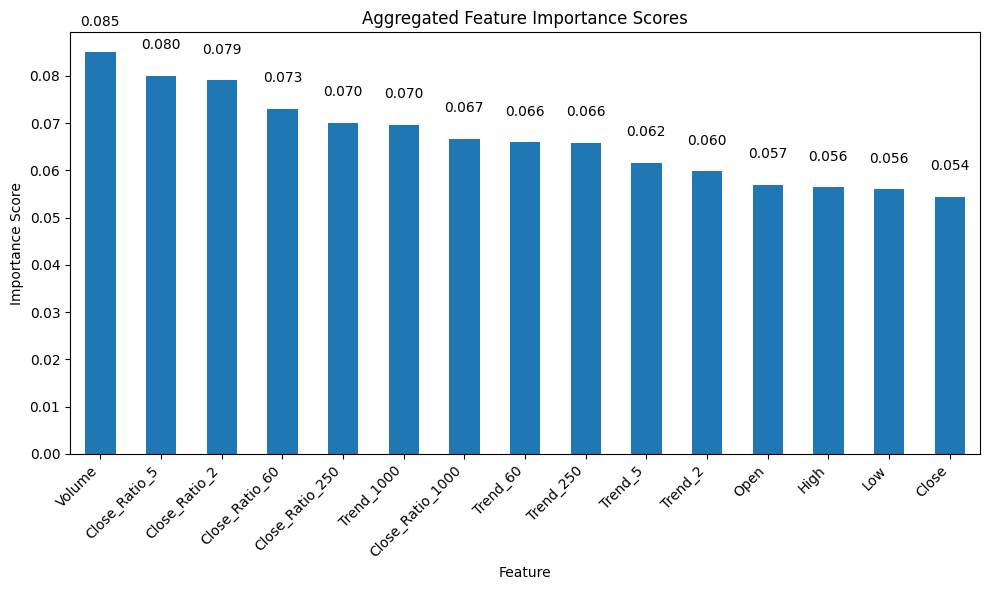

In [ ]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Directory containing trained models
models_dir = "/content/drive/MyDrive/prediction_models/"

# Feature names corresponding to their positions
feature_names = ["Close", "Volume", "Open", "High", "Low"] + [f"Close_Ratio_{h}" for h in [2, 5, 60, 250, 1000]] + [f"Trend_{h}" for h in [2, 5, 60, 250, 1000]]

# Create an empty dictionary to store feature importance scores for each feature
feature_importance_scores = {}

# Loop through each model file in the directory
for model_file in os.listdir(models_dir):
    if model_file.endswith(".pkl"):
        symbol = model_file.split("_")[0]
        try:
            # Load the model
            model_path = os.path.join(models_dir, model_file)
            model = joblib.load(model_path)

            # Extract feature importance if available
            if hasattr(model, 'feature_importances_'):
                # Store feature importance scores in the dictionary
                feature_importance_scores[symbol] = model.feature_importances_
            else:
                print(f"No feature importance available for model {model_file}")
        except Exception as e:
            print(f"Error occurred while processing model {model_file}: {e}")

# Convert the dictionary to a DataFrame for easier manipulation
feature_importance_df = pd.DataFrame.from_dict(feature_importance_scores, orient='index')

# Aggregate feature importance scores across all models (e.g., by taking the mean)
mean_feature_importance = feature_importance_df.mean(axis=0)

# Sort the aggregated feature importance scores
sorted_feature_importance = mean_feature_importance.sort_values(ascending=False)

# Create a bar plot to visualize the aggregated feature importance scores
plt.figure(figsize=(10, 6))
sorted_feature_importance.plot(kind='bar')
plt.title('Aggregated Feature Importance Scores')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.xticks(range(len(sorted_feature_importance)), [feature_names[idx] for idx in sorted_feature_importance.index], rotation=45, ha='right')
for i, v in enumerate(sorted_feature_importance):
    plt.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


The following is a visualization for the performance measures across all companies.


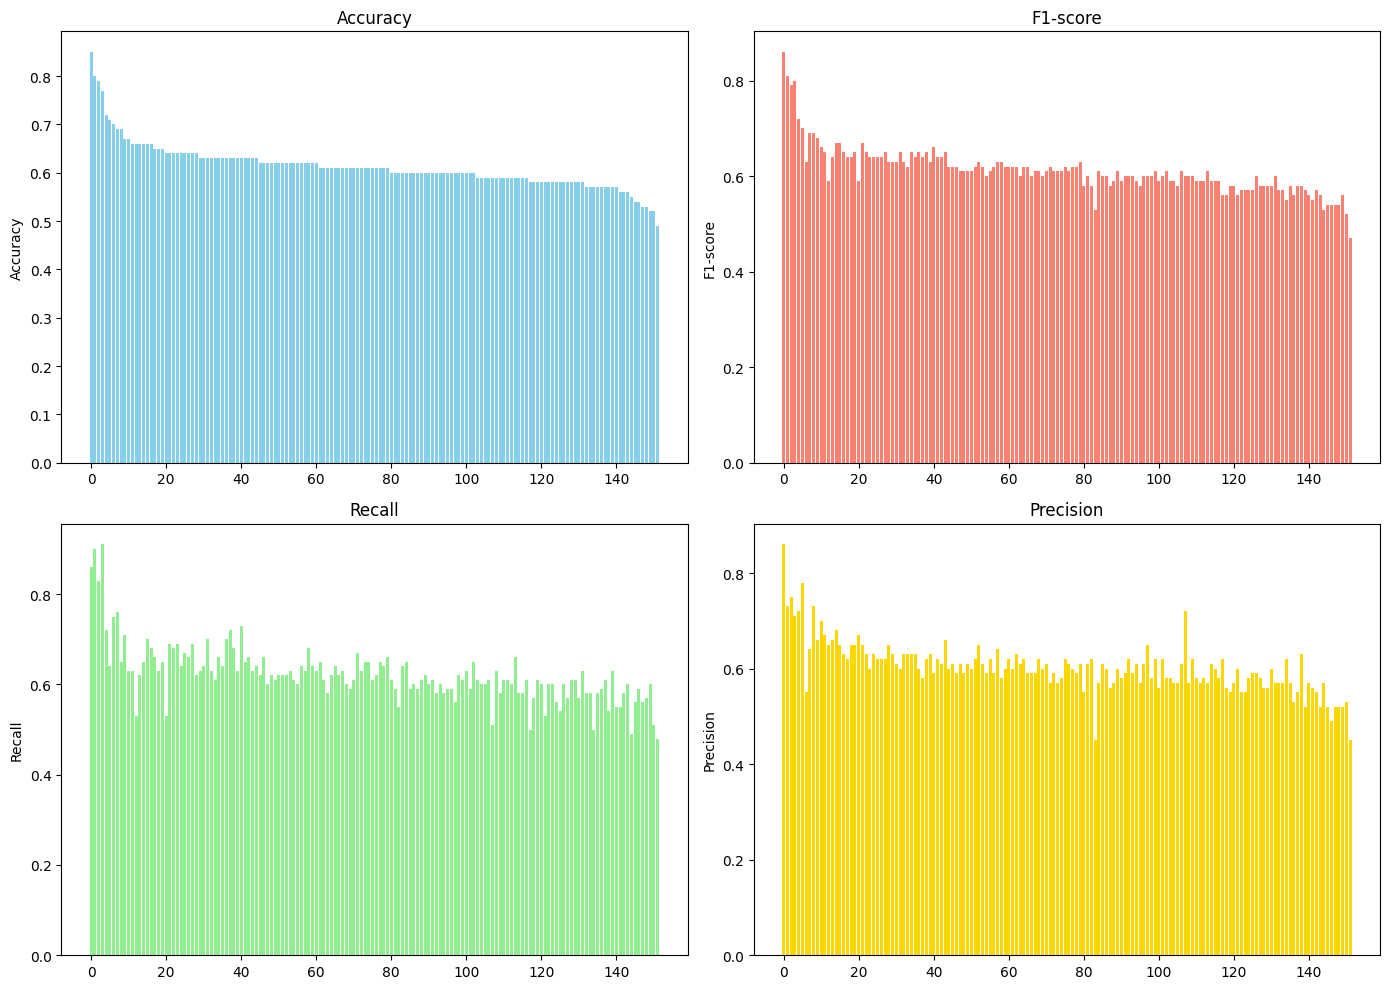

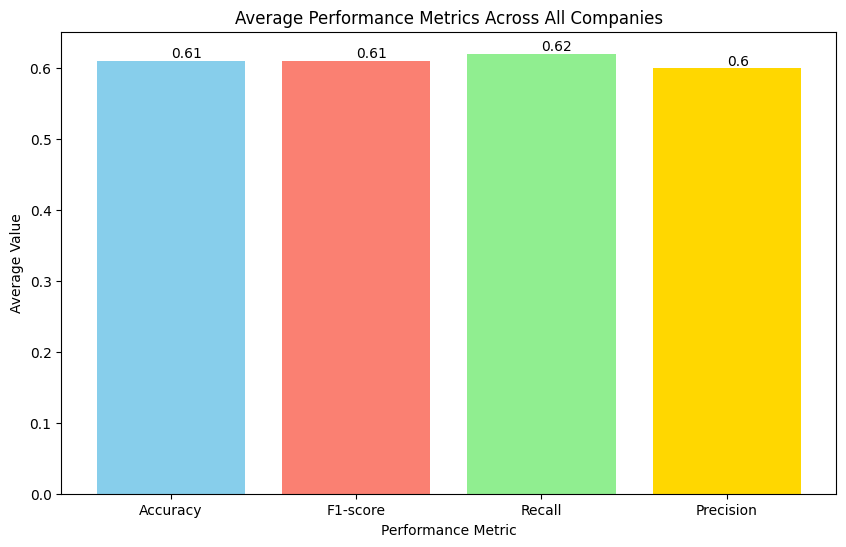

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Provided performance metrics text
performance_text = """
4012.SR: Accuracy=0.85, F1-score=0.86, Recall=0.86, Precision=0.86
7040.SR: Accuracy=0.8, F1-score=0.81, Recall=0.9, Precision=0.73
4130.SR: Accuracy=0.79, F1-score=0.79, Recall=0.83, Precision=0.75
2110.SR: Accuracy=0.77, F1-score=0.8, Recall=0.91, Precision=0.71
4345.SR: Accuracy=0.72, F1-score=0.72, Recall=0.72, Precision=0.72
6012.SR: Accuracy=0.71, F1-score=0.7, Recall=0.64, Precision=0.78
2222.SR: Accuracy=0.7, F1-score=0.63, Recall=0.75, Precision=0.55
4334.SR: Accuracy=0.69, F1-score=0.69, Recall=0.76, Precision=0.64
4336.SR: Accuracy=0.69, F1-score=0.69, Recall=0.65, Precision=0.73
4335.SR: Accuracy=0.67, F1-score=0.68, Recall=0.71, Precision=0.66
2360.SR: Accuracy=0.67, F1-score=0.66, Recall=0.63, Precision=0.7
4340.SR: Accuracy=0.66, F1-score=0.65, Recall=0.63, Precision=0.67
4338.SR: Accuracy=0.66, F1-score=0.59, Recall=0.53, Precision=0.65
3010.SR: Accuracy=0.66, F1-score=0.64, Recall=0.62, Precision=0.66
8311.SR: Accuracy=0.66, F1-score=0.67, Recall=0.65, Precision=0.68
6050.SR: Accuracy=0.66, F1-score=0.67, Recall=0.7, Precision=0.65
1030.SR: Accuracy=0.66, F1-score=0.65, Recall=0.68, Precision=0.63
3001.SR: Accuracy=0.65, F1-score=0.64, Recall=0.66, Precision=0.62
3040.SR: Accuracy=0.65, F1-score=0.64, Recall=0.63, Precision=0.65
2240.SR: Accuracy=0.65, F1-score=0.65, Recall=0.65, Precision=0.65
1820.SR: Accuracy=0.64, F1-score=0.59, Recall=0.53, Precision=0.67
3091.SR: Accuracy=0.64, F1-score=0.67, Recall=0.69, Precision=0.65
8180.SR: Accuracy=0.64, F1-score=0.65, Recall=0.68, Precision=0.63
4320.SR: Accuracy=0.64, F1-score=0.64, Recall=0.69, Precision=0.6
2160.SR: Accuracy=0.64, F1-score=0.64, Recall=0.64, Precision=0.63
4210.SR: Accuracy=0.64, F1-score=0.64, Recall=0.67, Precision=0.62
1810.SR: Accuracy=0.64, F1-score=0.64, Recall=0.66, Precision=0.62
4070.SR: Accuracy=0.64, F1-score=0.65, Recall=0.69, Precision=0.62
2100.SR: Accuracy=0.64, F1-score=0.63, Recall=0.62, Precision=0.65
2320.SR: Accuracy=0.63, F1-score=0.63, Recall=0.63, Precision=0.63
2280.SR: Accuracy=0.63, F1-score=0.63, Recall=0.64, Precision=0.61
8310.SR: Accuracy=0.63, F1-score=0.65, Recall=0.7, Precision=0.6
6002.SR: Accuracy=0.63, F1-score=0.63, Recall=0.63, Precision=0.63
4280.SR: Accuracy=0.63, F1-score=0.62, Recall=0.61, Precision=0.63
4100.SR: Accuracy=0.63, F1-score=0.65, Recall=0.66, Precision=0.63
7030.SR: Accuracy=0.63, F1-score=0.64, Recall=0.64, Precision=0.63
2210.SR: Accuracy=0.63, F1-score=0.65, Recall=0.7, Precision=0.6
4330.SR: Accuracy=0.63, F1-score=0.64, Recall=0.72, Precision=0.58
1060.SR: Accuracy=0.63, F1-score=0.65, Recall=0.68, Precision=0.62
3030.SR: Accuracy=0.63, F1-score=0.63, Recall=0.63, Precision=0.63
4006.SR: Accuracy=0.63, F1-score=0.66, Recall=0.73, Precision=0.59
4270.SR: Accuracy=0.63, F1-score=0.64, Recall=0.65, Precision=0.62
8200.SR: Accuracy=0.63, F1-score=0.64, Recall=0.66, Precision=0.61
4337.SR: Accuracy=0.63, F1-score=0.65, Recall=0.63, Precision=0.66
8060.SR: Accuracy=0.63, F1-score=0.62, Recall=0.64, Precision=0.6
4001.SR: Accuracy=0.62, F1-score=0.62, Recall=0.62, Precision=0.61
6020.SR: Accuracy=0.62, F1-score=0.62, Recall=0.66, Precision=0.59
6070.SR: Accuracy=0.62, F1-score=0.61, Recall=0.6, Precision=0.61
8012.SR: Accuracy=0.62, F1-score=0.61, Recall=0.62, Precision=0.59
4240.SR: Accuracy=0.62, F1-score=0.61, Recall=0.61, Precision=0.61
6001.SR: Accuracy=0.62, F1-score=0.61, Recall=0.62, Precision=0.6
4250.SR: Accuracy=0.62, F1-score=0.62, Recall=0.62, Precision=0.62
2370.SR: Accuracy=0.62, F1-score=0.63, Recall=0.62, Precision=0.65
4005.SR: Accuracy=0.62, F1-score=0.62, Recall=0.63, Precision=0.61
2380.SR: Accuracy=0.62, F1-score=0.6, Recall=0.61, Precision=0.59
4230.SR: Accuracy=0.62, F1-score=0.61, Recall=0.6, Precision=0.62
2040.SR: Accuracy=0.62, F1-score=0.62, Recall=0.64, Precision=0.59
5110.SR: Accuracy=0.62, F1-score=0.63, Recall=0.63, Precision=0.64
4140.SR: Accuracy=0.62, F1-score=0.63, Recall=0.68, Precision=0.58
3050.SR: Accuracy=0.62, F1-score=0.62, Recall=0.64, Precision=0.6
3090.SR: Accuracy=0.62, F1-score=0.62, Recall=0.63, Precision=0.62
2340.SR: Accuracy=0.61, F1-score=0.62, Recall=0.65, Precision=0.6
1214.SR: Accuracy=0.61, F1-score=0.62, Recall=0.61, Precision=0.63
8170.SR: Accuracy=0.61, F1-score=0.6, Recall=0.58, Precision=0.61
4080.SR: Accuracy=0.61, F1-score=0.62, Recall=0.62, Precision=0.62
6060.SR: Accuracy=0.61, F1-score=0.62, Recall=0.64, Precision=0.59
1020.SR: Accuracy=0.61, F1-score=0.6, Recall=0.62, Precision=0.59
3003.SR: Accuracy=0.61, F1-score=0.61, Recall=0.63, Precision=0.59
7020.SR: Accuracy=0.61, F1-score=0.61, Recall=0.6, Precision=0.62
8120.SR: Accuracy=0.61, F1-score=0.6, Recall=0.59, Precision=0.6
6090.SR: Accuracy=0.61, F1-score=0.61, Recall=0.61, Precision=0.61
4011.SR: Accuracy=0.61, F1-score=0.62, Recall=0.67, Precision=0.57
1202.SR: Accuracy=0.61, F1-score=0.61, Recall=0.63, Precision=0.59
1010.SR: Accuracy=0.61, F1-score=0.61, Recall=0.65, Precision=0.57
8080.SR: Accuracy=0.61, F1-score=0.61, Recall=0.65, Precision=0.58
8050.SR: Accuracy=0.61, F1-score=0.62, Recall=0.61, Precision=0.62
2050.SR: Accuracy=0.61, F1-score=0.61, Recall=0.62, Precision=0.61
1201.SR: Accuracy=0.61, F1-score=0.62, Recall=0.65, Precision=0.6
8190.SR: Accuracy=0.61, F1-score=0.62, Recall=0.64, Precision=0.59
2290.SR: Accuracy=0.61, F1-score=0.63, Recall=0.66, Precision=0.61
8280.SR: Accuracy=0.6, F1-score=0.58, Recall=0.61, Precision=0.55
1120.SR: Accuracy=0.6, F1-score=0.6, Recall=0.59, Precision=0.61
1080.SR: Accuracy=0.6, F1-score=0.58, Recall=0.55, Precision=0.62
4292.SR: Accuracy=0.6, F1-score=0.53, Recall=0.64, Precision=0.45
8270.SR: Accuracy=0.6, F1-score=0.61, Recall=0.65, Precision=0.57
4300.SR: Accuracy=0.6, F1-score=0.6, Recall=0.59, Precision=0.61
4180.SR: Accuracy=0.6, F1-score=0.6, Recall=0.6, Precision=0.6
8260.SR: Accuracy=0.6, F1-score=0.58, Recall=0.59, Precision=0.56
4190.SR: Accuracy=0.6, F1-score=0.59, Recall=0.61, Precision=0.57
4310.SR: Accuracy=0.6, F1-score=0.61, Recall=0.62, Precision=0.6
4009.SR: Accuracy=0.6, F1-score=0.59, Recall=0.6, Precision=0.58
6010.SR: Accuracy=0.6, F1-score=0.6, Recall=0.61, Precision=0.59
2220.SR: Accuracy=0.6, F1-score=0.6, Recall=0.58, Precision=0.62
2120.SR: Accuracy=0.6, F1-score=0.6, Recall=0.6, Precision=0.59
2030.SR: Accuracy=0.6, F1-score=0.59, Recall=0.58, Precision=0.61
4008.SR: Accuracy=0.6, F1-score=0.58, Recall=0.59, Precision=0.57
2350.SR: Accuracy=0.6, F1-score=0.6, Recall=0.59, Precision=0.61
2300.SR: Accuracy=0.6, F1-score=0.6, Recall=0.56, Precision=0.65
2270.SR: Accuracy=0.6, F1-score=0.6, Recall=0.62, Precision=0.58
4090.SR: Accuracy=0.6, F1-score=0.61, Recall=0.61, Precision=0.62
8030.SR: Accuracy=0.6, F1-score=0.59, Recall=0.63, Precision=0.56
3005.SR: Accuracy=0.6, F1-score=0.6, Recall=0.59, Precision=0.62
3007.SR: Accuracy=0.6, F1-score=0.61, Recall=0.65, Precision=0.58
1150.SR: Accuracy=0.59, F1-score=0.59, Recall=0.61, Precision=0.58
8070.SR: Accuracy=0.59, F1-score=0.59, Recall=0.6, Precision=0.57
1302.SR: Accuracy=0.59, F1-score=0.58, Recall=0.6, Precision=0.57
4004.SR: Accuracy=0.59, F1-score=0.61, Recall=0.61, Precision=0.61
1830.SR: Accuracy=0.59, F1-score=0.6, Recall=0.51, Precision=0.72
8020.SR: Accuracy=0.59, F1-score=0.6, Recall=0.63, Precision=0.57
2060.SR: Accuracy=0.59, F1-score=0.6, Recall=0.58, Precision=0.62
1211.SR: Accuracy=0.59, F1-score=0.59, Recall=0.61, Precision=0.58
2230.SR: Accuracy=0.59, F1-score=0.59, Recall=0.61, Precision=0.57
2070.SR: Accuracy=0.59, F1-score=0.59, Recall=0.6, Precision=0.58
4020.SR: Accuracy=0.59, F1-score=0.61, Recall=0.66, Precision=0.57
6040.SR: Accuracy=0.59, F1-score=0.59, Recall=0.58, Precision=0.61
4170.SR: Accuracy=0.59, F1-score=0.59, Recall=0.58, Precision=0.6
8300.SR: Accuracy=0.59, F1-score=0.59, Recall=0.61, Precision=0.58
4007.SR: Accuracy=0.58, F1-score=0.56, Recall=0.5, Precision=0.62
1212.SR: Accuracy=0.58, F1-score=0.56, Recall=0.57, Precision=0.56
8250.SR: Accuracy=0.58, F1-score=0.58, Recall=0.61, Precision=0.55
2140.SR: Accuracy=0.58, F1-score=0.58, Recall=0.6, Precision=0.57
1050.SR: Accuracy=0.58, F1-score=0.56, Recall=0.53, Precision=0.6
1210.SR: Accuracy=0.58, F1-score=0.57, Recall=0.6, Precision=0.55
4110.SR: Accuracy=0.58, F1-score=0.57, Recall=0.6, Precision=0.55
8240.SR: Accuracy=0.58, F1-score=0.57, Recall=0.56, Precision=0.58
4002.SR: Accuracy=0.58, F1-score=0.57, Recall=0.54, Precision=0.59
1213.SR: Accuracy=0.58, F1-score=0.6, Recall=0.6, Precision=0.59
2080.SR: Accuracy=0.58, F1-score=0.58, Recall=0.57, Precision=0.58
2010.SR: Accuracy=0.58, F1-score=0.58, Recall=0.61, Precision=0.56
4040.SR: Accuracy=0.58, F1-score=0.58, Recall=0.61, Precision=0.56
4260.SR: Accuracy=0.58, F1-score=0.58, Recall=0.57, Precision=0.6
3060.SR: Accuracy=0.58, F1-score=0.6, Recall=0.63, Precision=0.57
1140.SR: Accuracy=0.57, F1-score=0.57, Recall=0.58, Precision=0.57
8210.SR: Accuracy=0.57, F1-score=0.57, Recall=0.58, Precision=0.57
4339.SR: Accuracy=0.57, F1-score=0.55, Recall=0.5, Precision=0.62
1303.SR: Accuracy=0.57, F1-score=0.58, Recall=0.58, Precision=0.57
2090.SR: Accuracy=0.57, F1-score=0.56, Recall=0.59, Precision=0.53
1832.SR: Accuracy=0.57, F1-score=0.58, Recall=0.61, Precision=0.55
6004.SR: Accuracy=0.57, F1-score=0.58, Recall=0.54, Precision=0.63
1320.SR: Accuracy=0.57, F1-score=0.57, Recall=0.63, Precision=0.52
3020.SR: Accuracy=0.57, F1-score=0.56, Recall=0.55, Precision=0.57
2180.SR: Accuracy=0.56, F1-score=0.55, Recall=0.55, Precision=0.56
1180.SR: Accuracy=0.56, F1-score=0.57, Recall=0.58, Precision=0.55
4003.SR: Accuracy=0.56, F1-score=0.56, Recall=0.6, Precision=0.52
2190.SR: Accuracy=0.55, F1-score=0.53, Recall=0.49, Precision=0.57
8150.SR: Accuracy=0.54, F1-score=0.54, Recall=0.56, Precision=0.52
8100.SR: Accuracy=0.54, F1-score=0.54, Recall=0.59, Precision=0.49
4031.SR: Accuracy=0.53, F1-score=0.54, Recall=0.56, Precision=0.52
2250.SR: Accuracy=0.53, F1-score=0.54, Recall=0.57, Precision=0.52
1304.SR: Accuracy=0.52, F1-score=0.56, Recall=0.6, Precision=0.52
2150.SR: Accuracy=0.52, F1-score=0.52, Recall=0.51, Precision=0.53
1831.SR: Accuracy=0.49, F1-score=0.47, Recall=0.48, Precision=0.45

"""
# Define lists to store performance metrics
accuracies = []
f1_scores = []
recalls = []
precisions = []

# Parse the text and extract performance metrics for each company
for line in performance_text.strip().split('\n'):
    match = re.match(r'\d+\.SR: Accuracy=(\d\.\d+), F1-score=(\d\.\d+), Recall=(\d\.\d+), Precision=(\d\.\d+)', line)
    if match:
        accuracy, f1_score, recall, precision = map(float, match.groups())
        accuracies.append(accuracy)
        f1_scores.append(f1_score)
        recalls.append(recall)
        precisions.append(precision)

# Convert lists to numpy arrays for plotting
accuracies = np.array(accuracies)
f1_scores = np.array(f1_scores)
recalls = np.array(recalls)
precisions = np.array(precisions)

# Calculate average performance metrics across all companies
average_accuracy = round(np.mean(accuracies), 2)
average_f1_score = round(np.mean(f1_scores), 2)
average_recall = round(np.mean(recalls), 2)
average_precision = round(np.mean(precisions), 2)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].bar(range(len(accuracies)), accuracies, color='skyblue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Accuracy')

# F1-score
axs[0, 1].bar(range(len(f1_scores)), f1_scores, color='salmon')
axs[0, 1].set_title('F1-score')
axs[0, 1].set_ylabel('F1-score')

# Recall
axs[1, 0].bar(range(len(recalls)), recalls, color='lightgreen')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Recall')

# Precision
axs[1, 1].bar(range(len(precisions)), precisions, color='gold')
axs[1, 1].set_title('Precision')
axs[1, 1].set_ylabel('Precision')

plt.tight_layout()
plt.show()

# Simple plot showing the average performance measures across all companies
metrics = ['Accuracy', 'F1-score', 'Recall', 'Precision']
average_values = [average_accuracy, average_f1_score, average_recall, average_precision]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, average_values, color=['skyblue', 'salmon', 'lightgreen', 'gold'])

# Add values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.title('Average Performance Metrics Across All Companies')
plt.xlabel('Performance Metric')
plt.ylabel('Average Value')
plt.show()


The following code shows a visualization for the best hyperparameters across all companies.

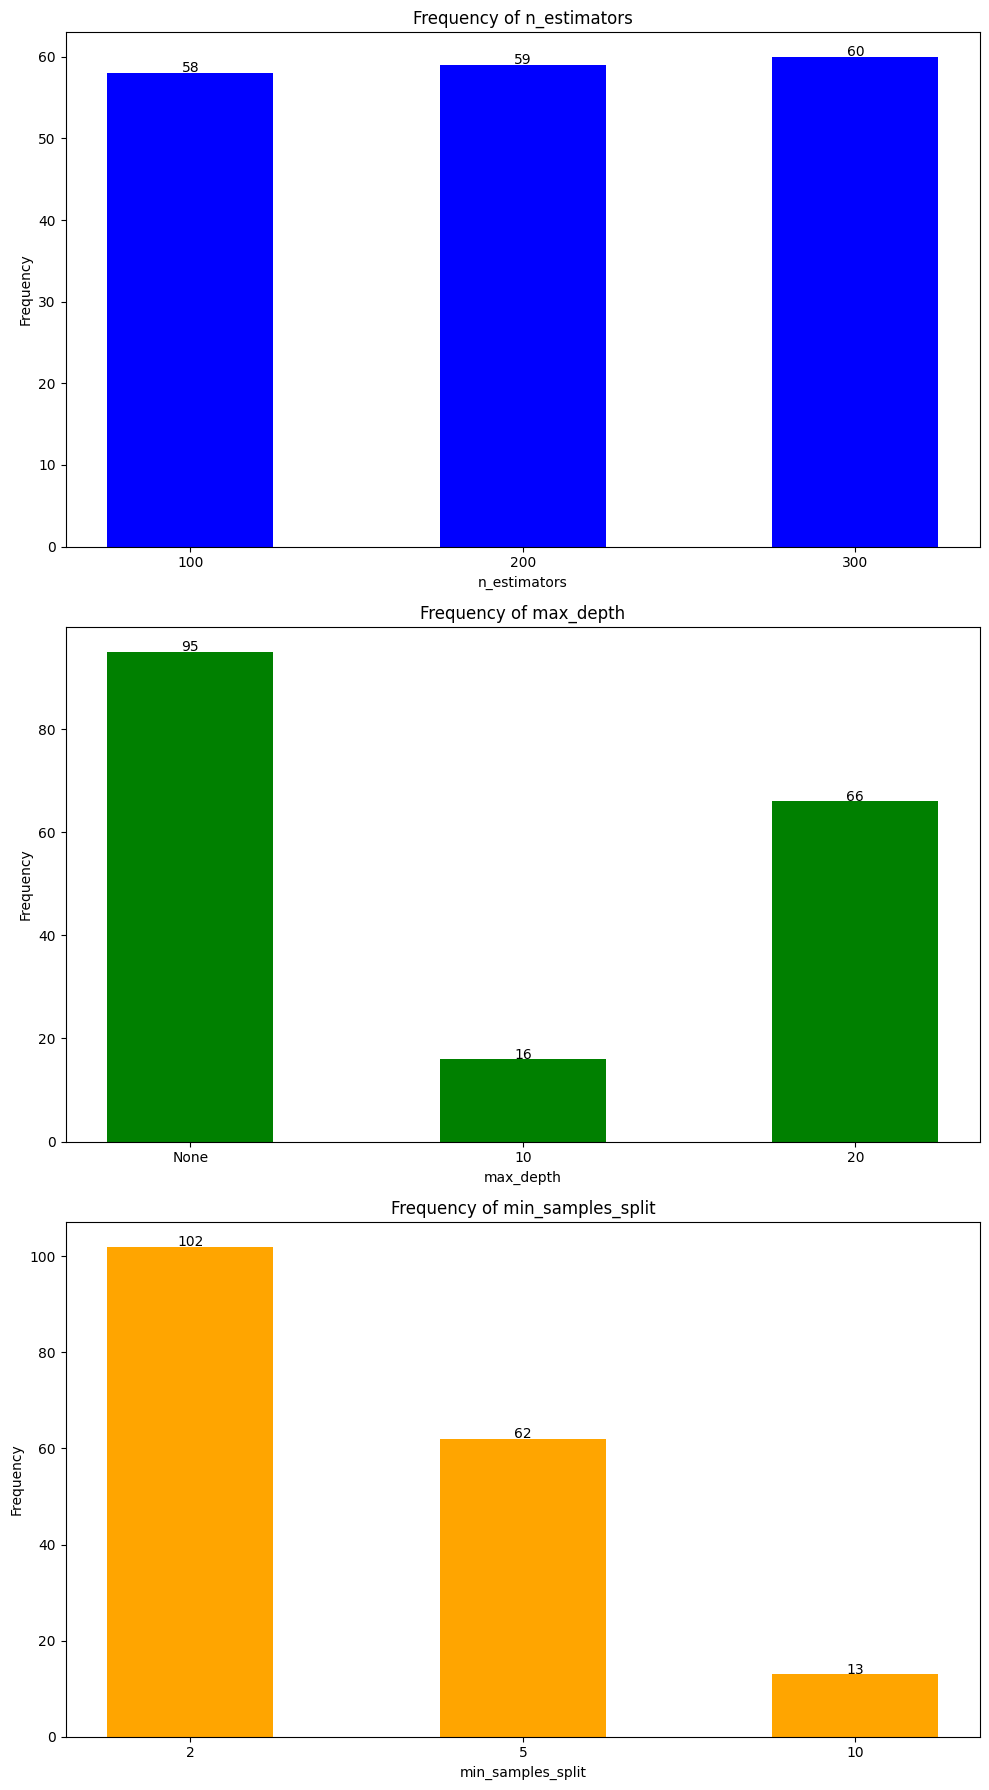

In [ ]:
import re
import matplotlib.pyplot as plt

# Initialize counters for hyperparameter settings
param_counts = {
    'n_estimators': {100: 0, 200: 0, 300: 0},
    'max_depth': {None: 0, 10: 0, 20: 0},
    'min_samples_split': {2: 0, 5: 0, 10: 0}
}

# Text containing the best hyperparameters for each company
hyperparameter_text = """
Data for 4001.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4001.SR_model.pkl
Model trained successfully for 4001.SR. Accuracy: 0.62, F1-score: 0.62, Recall: 0.62, Precision: 0.61
Data for 1820.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/1820.SR_model.pkl
Model trained successfully for 1820.SR. Accuracy: 0.64, F1-score: 0.59, Recall: 0.53, Precision: 0.67
Data for 2082.SR saved successfully.
No data available after feature engineering for 2082.SR. Skipping training.
Data for 2330.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2330.SR_model.pkl
Model trained successfully for 2330.SR. Accuracy: 0.61, F1-score: 0.64, Recall: 0.65, Precision: 0.63
Data for 2340.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2340.SR_model.pkl
Model trained successfully for 2340.SR. Accuracy: 0.61, F1-score: 0.62, Recall: 0.65, Precision: 0.60
Data for 8280.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/8280.SR_model.pkl
Model trained successfully for 8280.SR. Accuracy: 0.60, F1-score: 0.58, Recall: 0.61, Precision: 0.55
Data for 6020.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/6020.SR_model.pkl
Model trained successfully for 6020.SR. Accuracy: 0.62, F1-score: 0.62, Recall: 0.66, Precision: 0.59
Data for 4007.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4007.SR_model.pkl
Model trained successfully for 4007.SR. Accuracy: 0.58, F1-score: 0.56, Recall: 0.50, Precision: 0.62
Data for 1214.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/1214.SR_model.pkl
Model trained successfully for 1214.SR. Accuracy: 0.61, F1-score: 0.62, Recall: 0.61, Precision: 0.63
Data for 3091.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/3091.SR_model.pkl
Model trained successfully for 3091.SR. Accuracy: 0.64, F1-score: 0.67, Recall: 0.69, Precision: 0.65
Data for 4334.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4334.SR_model.pkl
Model trained successfully for 4334.SR. Accuracy: 0.69, F1-score: 0.69, Recall: 0.76, Precision: 0.64
Data for 1120.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/1120.SR_model.pkl
Model trained successfully for 1120.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.59, Precision: 0.61
Data for 4340.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4340.SR_model.pkl
Model trained successfully for 4340.SR. Accuracy: 0.66, F1-score: 0.65, Recall: 0.63, Precision: 0.67
Data for 8180.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/8180.SR_model.pkl
Model trained successfully for 8180.SR. Accuracy: 0.64, F1-score: 0.65, Recall: 0.68, Precision: 0.63
Data for 1304.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1304.SR_model.pkl
Model trained successfully for 1304.SR. Accuracy: 0.52, F1-score: 0.56, Recall: 0.60, Precision: 0.52
Data for 2320.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2320.SR_model.pkl
Model trained successfully for 2320.SR. Accuracy: 0.63, F1-score: 0.63, Recall: 0.63, Precision: 0.63
Data for 4130.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4130.SR_model.pkl
Model trained successfully for 4130.SR. Accuracy: 0.79, F1-score: 0.79, Recall: 0.83, Precision: 0.75
Data for 8170.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8170.SR_model.pkl
Model trained successfully for 8170.SR. Accuracy: 0.61, F1-score: 0.60, Recall: 0.58, Precision: 0.61
Data for 6070.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/6070.SR_model.pkl
Model trained successfully for 6070.SR. Accuracy: 0.62, F1-score: 0.61, Recall: 0.60, Precision: 0.61
Data for 4141.SR saved successfully.
No data available after feature engineering for 4141.SR. Skipping training.
Data for 8230.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8230.SR_model.pkl
Model trained successfully for 8230.SR. Accuracy: 0.57, F1-score: 0.58, Recall: 0.61, Precision: 0.55
Data for 4338.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4338.SR_model.pkl
Model trained successfully for 4338.SR. Accuracy: 0.66, F1-score: 0.59, Recall: 0.53, Precision: 0.65
Data for 4320.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4320.SR_model.pkl
Model trained successfully for 4320.SR. Accuracy: 0.64, F1-score: 0.64, Recall: 0.69, Precision: 0.60
Data for 4163.SR saved successfully.
No data available after feature engineering for 4163.SR. Skipping training.
Data for 4200.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4200.SR_model.pkl
Model trained successfully for 4200.SR. Accuracy: 0.57, F1-score: 0.58, Recall: 0.59, Precision: 0.58
Data for 1150.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/1150.SR_model.pkl
Model trained successfully for 1150.SR. Accuracy: 0.59, F1-score: 0.59, Recall: 0.61, Precision: 0.58
ERROR:yfinance:8312.SR: No timezone found, symbol may be delisted
Data for 8312.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 8312.SR. Skipping training.
Data for 4331.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4331.SR_model.pkl
Model trained successfully for 4331.SR. Accuracy: 0.70, F1-score: 0.70, Recall: 0.68, Precision: 0.72
Data for 8012.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/8012.SR_model.pkl
Model trained successfully for 8012.SR. Accuracy: 0.62, F1-score: 0.61, Recall: 0.62, Precision: 0.59
Data for 4348.SR saved successfully.
No data available after feature engineering for 4348.SR. Skipping training.
Data for 4290.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4290.SR_model.pkl
Model trained successfully for 4290.SR. Accuracy: 0.59, F1-score: 0.60, Recall: 0.64, Precision: 0.56
Data for 2081.SR saved successfully.
No data available after feature engineering for 2081.SR. Skipping training.
Data for 8040.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8040.SR_model.pkl
Model trained successfully for 8040.SR. Accuracy: 0.57, F1-score: 0.58, Recall: 0.60, Precision: 0.56
Data for 8150.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/8150.SR_model.pkl
Model trained successfully for 8150.SR. Accuracy: 0.54, F1-score: 0.54, Recall: 0.56, Precision: 0.52
Data for 2280.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2280.SR_model.pkl
Model trained successfully for 2280.SR. Accuracy: 0.63, F1-score: 0.63, Recall: 0.64, Precision: 0.61
Data for 1322.SR saved successfully.
No data available after feature engineering for 1322.SR. Skipping training.
Data for 4162.SR saved successfully.
No data available after feature engineering for 4162.SR. Skipping training.
Data for 2170.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2170.SR_model.pkl
Model trained successfully for 2170.SR. Accuracy: 0.62, F1-score: 0.63, Recall: 0.68, Precision: 0.59
Data for 8310.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/8310.SR_model.pkl
Model trained successfully for 8310.SR. Accuracy: 0.63, F1-score: 0.65, Recall: 0.70, Precision: 0.60
Data for 1182.SR saved successfully.
No data available after feature engineering for 1182.SR. Skipping training.
Data for 4061.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4061.SR_model.pkl
Model trained successfully for 4061.SR. Accuracy: 0.63, F1-score: 0.62, Recall: 0.63, Precision: 0.61
Data for 1080.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1080.SR_model.pkl
Model trained successfully for 1080.SR. Accuracy: 0.60, F1-score: 0.58, Recall: 0.55, Precision: 0.62
Data for 7201.SR saved successfully.
No data available after feature engineering for 7201.SR. Skipping training.
Data for 8160.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/8160.SR_model.pkl
Model trained successfully for 8160.SR. Accuracy: 0.60, F1-score: 0.62, Recall: 0.64, Precision: 0.60
Data for 3010.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/3010.SR_model.pkl
Model trained successfully for 3010.SR. Accuracy: 0.66, F1-score: 0.64, Recall: 0.62, Precision: 0.66
Data for 4071.SR saved successfully.
No data available after feature engineering for 4071.SR. Skipping training.
Data for 7202.SR saved successfully.
No data available after feature engineering for 7202.SR. Skipping training.
Data for 2200.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2200.SR_model.pkl
Model trained successfully for 2200.SR. Accuracy: 0.61, F1-score: 0.59, Recall: 0.57, Precision: 0.62
Data for 8070.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8070.SR_model.pkl
Model trained successfully for 8070.SR. Accuracy: 0.59, F1-score: 0.59, Recall: 0.60, Precision: 0.57
Data for 4080.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4080.SR_model.pkl
Model trained successfully for 4080.SR. Accuracy: 0.61, F1-score: 0.62, Recall: 0.62, Precision: 0.62
Data for 6060.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/6060.SR_model.pkl
Model trained successfully for 6060.SR. Accuracy: 0.61, F1-score: 0.62, Recall: 0.64, Precision: 0.59
Data for 1212.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/1212.SR_model.pkl
Model trained successfully for 1212.SR. Accuracy: 0.58, F1-score: 0.56, Recall: 0.57, Precision: 0.56
Data for 4292.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4292.SR_model.pkl
Model trained successfully for 4292.SR. Accuracy: 0.60, F1-score: 0.53, Recall: 0.64, Precision: 0.45
Data for 8250.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8250.SR_model.pkl
Model trained successfully for 8250.SR. Accuracy: 0.58, F1-score: 0.58, Recall: 0.61, Precision: 0.55
Data for 2140.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2140.SR_model.pkl
Model trained successfully for 2140.SR. Accuracy: 0.58, F1-score: 0.58, Recall: 0.60, Precision: 0.57
Data for 1140.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1140.SR_model.pkl
Model trained successfully for 1140.SR. Accuracy: 0.57, F1-score: 0.57, Recall: 0.58, Precision: 0.57
Data for 1020.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1020.SR_model.pkl
Model trained successfully for 1020.SR. Accuracy: 0.61, F1-score: 0.60, Recall: 0.62, Precision: 0.59
Data for 1050.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/1050.SR_model.pkl
Model trained successfully for 1050.SR. Accuracy: 0.58, F1-score: 0.56, Recall: 0.53, Precision: 0.60
Data for 1210.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1210.SR_model.pkl
Model trained successfully for 1210.SR. Accuracy: 0.58, F1-score: 0.57, Recall: 0.60, Precision: 0.55
Data for 4110.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4110.SR_model.pkl
Model trained successfully for 4110.SR. Accuracy: 0.58, F1-score: 0.57, Recall: 0.60, Precision: 0.55
Data for 1302.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/1302.SR_model.pkl
Model trained successfully for 1302.SR. Accuracy: 0.59, F1-score: 0.58, Recall: 0.60, Precision: 0.57
Data for 4161.SR saved successfully.
No data available after feature engineering for 4161.SR. Skipping training.
Data for 4347.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4347.SR_model.pkl
Model trained successfully for 4347.SR. Accuracy: 0.66, F1-score: 0.66, Recall: 0.65, Precision: 0.67
Data for 8210.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8210.SR_model.pkl
Model trained successfully for 8210.SR. Accuracy: 0.57, F1-score: 0.57, Recall: 0.58, Precision: 0.57
Data for 8270.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/8270.SR_model.pkl
Model trained successfully for 8270.SR. Accuracy: 0.60, F1-score: 0.61, Recall: 0.65, Precision: 0.57
Data for 8240.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/8240.SR_model.pkl
Model trained successfully for 8240.SR. Accuracy: 0.58, F1-score: 0.57, Recall: 0.56, Precision: 0.58
Data for 3003.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/3003.SR_model.pkl
Model trained successfully for 3003.SR. Accuracy: 0.61, F1-score: 0.61, Recall: 0.63, Precision: 0.59
Data for 4004.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4004.SR_model.pkl
Model trained successfully for 4004.SR. Accuracy: 0.59, F1-score: 0.61, Recall: 0.61, Precision: 0.61
Data for 4300.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4300.SR_model.pkl
Model trained successfully for 4300.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.59, Precision: 0.61
Data for 4339.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4339.SR_model.pkl
Model trained successfully for 4339.SR. Accuracy: 0.57, F1-score: 0.55, Recall: 0.50, Precision: 0.62
Data for 6013.SR saved successfully.
No data available after feature engineering for 6013.SR. Skipping training.
Data for 4013.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4013.SR_model.pkl
Model trained successfully for 4013.SR. Accuracy: 0.25, F1-score: 0.40, Recall: 1.00, Precision: 0.25
ERROR:yfinance:4010.SR: No timezone found, symbol may be delisted
Data for 4010.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 4010.SR. Skipping training.
Data for 1321.SR saved successfully.
No data available after feature engineering for 1321.SR. Skipping training.
Data for 3080.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/3080.SR_model.pkl
Model trained successfully for 3080.SR. Accuracy: 0.59, F1-score: 0.60, Recall: 0.61, Precision: 0.59
Data for 1303.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/1303.SR_model.pkl
Model trained successfully for 1303.SR. Accuracy: 0.57, F1-score: 0.58, Recall: 0.58, Precision: 0.57
Data for 7203.SR saved successfully.
No data available after feature engineering for 7203.SR. Skipping training.
Data for 4220.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4220.SR_model.pkl
Model trained successfully for 4220.SR. Accuracy: 0.60, F1-score: 0.59, Recall: 0.58, Precision: 0.60
Data for 7040.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/7040.SR_model.pkl
Model trained successfully for 7040.SR. Accuracy: 0.80, F1-score: 0.81, Recall: 0.90, Precision: 0.73
Data for 7020.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/7020.SR_model.pkl
Model trained successfully for 7020.SR. Accuracy: 0.61, F1-score: 0.61, Recall: 0.60, Precision: 0.62
Data for 4240.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4240.SR_model.pkl
Model trained successfully for 4240.SR. Accuracy: 0.62, F1-score: 0.61, Recall: 0.61, Precision: 0.61
Data for 2180.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2180.SR_model.pkl
Model trained successfully for 2180.SR. Accuracy: 0.56, F1-score: 0.55, Recall: 0.55, Precision: 0.56
Data for 4180.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4180.SR_model.pkl
Model trained successfully for 4180.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.60, Precision: 0.60
Data for 8260.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8260.SR_model.pkl
Model trained successfully for 8260.SR. Accuracy: 0.60, F1-score: 0.58, Recall: 0.59, Precision: 0.56
Data for 8120.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/8120.SR_model.pkl
Model trained successfully for 8120.SR. Accuracy: 0.61, F1-score: 0.60, Recall: 0.59, Precision: 0.60
Data for 3001.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/3001.SR_model.pkl
Model trained successfully for 3001.SR. Accuracy: 0.65, F1-score: 0.64, Recall: 0.66, Precision: 0.62
Data for 6001.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/6001.SR_model.pkl
Model trained successfully for 6001.SR. Accuracy: 0.62, F1-score: 0.61, Recall: 0.62, Precision: 0.60
Data for 6002.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/6002.SR_model.pkl
Model trained successfully for 6002.SR. Accuracy: 0.63, F1-score: 0.63, Recall: 0.63, Precision: 0.63
Data for 4250.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4250.SR_model.pkl
Model trained successfully for 4250.SR. Accuracy: 0.62, F1-score: 0.62, Recall: 0.62, Precision: 0.62
Data for 4332.SR saved successfully.
No data available after feature engineering for 4332.SR. Skipping training.
Data for 4342.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4342.SR_model.pkl
Model trained successfully for 4342.SR. Accuracy: 0.66, F1-score: 0.68, Recall: 0.68, Precision: 0.69
Data for 4190.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4190.SR_model.pkl
Model trained successfully for 4190.SR. Accuracy: 0.60, F1-score: 0.59, Recall: 0.61, Precision: 0.57
Data for 6090.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/6090.SR_model.pkl
Model trained successfully for 6090.SR. Accuracy: 0.61, F1-score: 0.61, Recall: 0.61, Precision: 0.61
Data for 4280.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4280.SR_model.pkl
Model trained successfully for 4280.SR. Accuracy: 0.63, F1-score: 0.62, Recall: 0.61, Precision: 0.63
Data for 4310.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4310.SR_model.pkl
Model trained successfully for 4310.SR. Accuracy: 0.60, F1-score: 0.61, Recall: 0.62, Precision: 0.60
Data for 4011.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4011.SR_model.pkl
Model trained successfully for 4011.SR. Accuracy: 0.61, F1-score: 0.62, Recall: 0.67, Precision: 0.57
Data for 1830.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1830.SR_model.pkl
Model trained successfully for 1830.SR. Accuracy: 0.59, F1-score: 0.60, Recall: 0.51, Precision: 0.72
Data for 1831.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1831.SR_model.pkl
Model trained successfully for 1831.SR. Accuracy: 0.49, F1-score: 0.47, Recall: 0.48, Precision: 0.45
Data for 4100.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4100.SR_model.pkl
Model trained successfully for 4100.SR. Accuracy: 0.63, F1-score: 0.65, Recall: 0.66, Precision: 0.63
Data for 8020.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8020.SR_model.pkl
Model trained successfully for 8020.SR. Accuracy: 0.59, F1-score: 0.60, Recall: 0.63, Precision: 0.57
Data for 4346.SR saved successfully.
No data available after feature engineering for 4346.SR. Skipping training.
Data for 2001.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2001.SR_model.pkl
Model trained successfully for 2001.SR. Accuracy: 0.59, F1-score: 0.60, Recall: 0.63, Precision: 0.56
Data for 4009.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4009.SR_model.pkl
Model trained successfully for 4009.SR. Accuracy: 0.60, F1-score: 0.59, Recall: 0.60, Precision: 0.58
Data for 1202.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/1202.SR_model.pkl
Model trained successfully for 1202.SR. Accuracy: 0.61, F1-score: 0.61, Recall: 0.63, Precision: 0.59
Data for 2370.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2370.SR_model.pkl
Model trained successfully for 2370.SR. Accuracy: 0.62, F1-score: 0.63, Recall: 0.62, Precision: 0.65
Data for 7030.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/7030.SR_model.pkl
Model trained successfully for 7030.SR. Accuracy: 0.63, F1-score: 0.64, Recall: 0.64, Precision: 0.63
Data for 4002.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4002.SR_model.pkl
Model trained successfully for 4002.SR. Accuracy: 0.58, F1-score: 0.57, Recall: 0.54, Precision: 0.59
Data for 4336.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4336.SR_model.pkl
Model trained successfully for 4336.SR. Accuracy: 0.69, F1-score: 0.69, Recall: 0.65, Precision: 0.73
Data for 4335.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4335.SR_model.pkl
Model trained successfully for 4335.SR. Accuracy: 0.67, F1-score: 0.68, Recall: 0.71, Precision: 0.66
Data for 4164.SR saved successfully.
No data available after feature engineering for 4164.SR. Skipping training.
Data for 3002.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/3002.SR_model.pkl
Model trained successfully for 3002.SR. Accuracy: 0.63, F1-score: 0.62, Recall: 0.61, Precision: 0.64
Data for 2210.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2210.SR_model.pkl
Model trained successfully for 2210.SR. Accuracy: 0.63, F1-score: 0.65, Recall: 0.70, Precision: 0.60
Data for 1213.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1213.SR_model.pkl
Model trained successfully for 1213.SR. Accuracy: 0.58, F1-score: 0.60, Recall: 0.60, Precision: 0.59
Data for 6010.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/6010.SR_model.pkl
Model trained successfully for 6010.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.61, Precision: 0.59
Data for 2080.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2080.SR_model.pkl
Model trained successfully for 2080.SR. Accuracy: 0.58, F1-score: 0.58, Recall: 0.57, Precision: 0.58
Data for 2090.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2090.SR_model.pkl
Model trained successfully for 2090.SR. Accuracy: 0.57, F1-score: 0.56, Recall: 0.59, Precision: 0.53
Data for 2060.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2060.SR_model.pkl
Model trained successfully for 2060.SR. Accuracy: 0.59, F1-score: 0.60, Recall: 0.58, Precision: 0.62
Data for 4005.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4005.SR_model.pkl
Model trained successfully for 4005.SR. Accuracy: 0.62, F1-score: 0.62, Recall: 0.63, Precision: 0.61
Data for 2220.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2220.SR_model.pkl
Model trained successfully for 2220.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.58, Precision: 0.62
ERROR:yfinance:2002.SR: No timezone found, symbol may be delisted
Data for 2002.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 2002.SR. Skipping training.
Data for 4030.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4030.SR_model.pkl
Model trained successfully for 4030.SR. Accuracy: 0.55, F1-score: 0.55, Recall: 0.54, Precision: 0.55
Data for 4081.SR saved successfully.
No data available after feature engineering for 4081.SR. Skipping training.
Data for 3004.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/3004.SR_model.pkl
Model trained successfully for 3004.SR. Accuracy: 0.66, F1-score: 0.68, Recall: 0.70, Precision: 0.66
Data for 3040.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/3040.SR_model.pkl
Model trained successfully for 3040.SR. Accuracy: 0.65, F1-score: 0.64, Recall: 0.63, Precision: 0.65
Data for 2380.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2380.SR_model.pkl
Model trained successfully for 2380.SR. Accuracy: 0.62, F1-score: 0.60, Recall: 0.61, Precision: 0.59
Data for 6012.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/6012.SR_model.pkl
Model trained successfully for 6012.SR. Accuracy: 0.71, F1-score: 0.70, Recall: 0.64, Precision: 0.78
Data for 4230.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4230.SR_model.pkl
Model trained successfully for 4230.SR. Accuracy: 0.62, F1-score: 0.61, Recall: 0.60, Precision: 0.62
Data for 1010.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/1010.SR_model.pkl
Model trained successfully for 1010.SR. Accuracy: 0.61, F1-score: 0.61, Recall: 0.65, Precision: 0.57
Data for 4330.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4330.SR_model.pkl
Model trained successfully for 4330.SR. Accuracy: 0.63, F1-score: 0.64, Recall: 0.72, Precision: 0.58
ERROR:yfinance:8080.SR: No timezone found, symbol may be delisted
Data for 8080.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 8080.SR. Skipping training.
Data for 2020.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2020.SR_model.pkl
Model trained successfully for 2020.SR. Accuracy: 0.61, F1-score: 0.61, Recall: 0.65, Precision: 0.58
Data for 1832.SR saved successfully.
No data available after feature engineering for 1832.SR. Skipping training.
Data for 2310.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2310.SR_model.pkl
Model trained successfully for 2310.SR. Accuracy: 0.57, F1-score: 0.58, Recall: 0.61, Precision: 0.55
Data for 8050.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/8050.SR_model.pkl
Model trained successfully for 8050.SR. Accuracy: 0.61, F1-score: 0.62, Recall: 0.61, Precision: 0.62
Data for 2120.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2120.SR_model.pkl
Model trained successfully for 2120.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.60, Precision: 0.59
Data for 6004.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/6004.SR_model.pkl
Model trained successfully for 6004.SR. Accuracy: 0.57, F1-score: 0.58, Recall: 0.54, Precision: 0.63
Data for 2030.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2030.SR_model.pkl
Model trained successfully for 2030.SR. Accuracy: 0.60, F1-score: 0.59, Recall: 0.58, Precision: 0.61
Data for 2160.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2160.SR_model.pkl
Model trained successfully for 2160.SR. Accuracy: 0.64, F1-score: 0.64, Recall: 0.64, Precision: 0.63
Data for 8100.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/8100.SR_model.pkl
Model trained successfully for 8100.SR. Accuracy: 0.54, F1-score: 0.54, Recall: 0.59, Precision: 0.49
Data for 1211.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1211.SR_model.pkl
Model trained successfully for 1211.SR. Accuracy: 0.59, F1-score: 0.59, Recall: 0.61, Precision: 0.58
Data for 2222.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2222.SR_model.pkl
Model trained successfully for 2222.SR. Accuracy: 0.70, F1-score: 0.63, Recall: 0.75, Precision: 0.55
Data for 2010.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2010.SR_model.pkl
Model trained successfully for 2010.SR. Accuracy: 0.58, F1-score: 0.58, Recall: 0.61, Precision: 0.56
Data for 1060.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/1060.SR_model.pkl
Model trained successfully for 1060.SR. Accuracy: 0.63, F1-score: 0.65, Recall: 0.68, Precision: 0.62
Data for 2110.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2110.SR_model.pkl
Model trained successfully for 2110.SR. Accuracy: 0.77, F1-score: 0.80, Recall: 0.91, Precision: 0.71
Data for 3030.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/3030.SR_model.pkl
Model trained successfully for 3030.SR. Accuracy: 0.63, F1-score: 0.63, Recall: 0.63, Precision: 0.63
Data for 2040.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2040.SR_model.pkl
Model trained successfully for 2040.SR. Accuracy: 0.62, F1-score: 0.62, Recall: 0.64, Precision: 0.59
Data for 2230.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2230.SR_model.pkl
Model trained successfully for 2230.SR. Accuracy: 0.59, F1-score: 0.59, Recall: 0.61, Precision: 0.57
Data for 4008.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4008.SR_model.pkl
Model trained successfully for 4008.SR. Accuracy: 0.60, F1-score: 0.58, Recall: 0.59, Precision: 0.57
Data for 5110.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/5110.SR_model.pkl
Model trained successfully for 5110.SR. Accuracy: 0.62, F1-score: 0.63, Recall: 0.63, Precision: 0.64
Data for 8311.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8311.SR_model.pkl
Model trained successfully for 8311.SR. Accuracy: 0.66, F1-score: 0.67, Recall: 0.65, Precision: 0.68
Data for 6050.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/6050.SR_model.pkl
Model trained successfully for 6050.SR. Accuracy: 0.66, F1-score: 0.67, Recall: 0.70, Precision: 0.65
Data for 4031.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4031.SR_model.pkl
Model trained successfully for 4031.SR. Accuracy: 0.53, F1-score: 0.54, Recall: 0.56, Precision: 0.52
ERROR:yfinance:8110.SR: No timezone found, symbol may be delisted
Data for 8110.SR saved successfully.
Columns 'Dividends' and/or 'Stock Splits' not found. Skipping deletion.
No data available for 8110.SR. Skipping training.
Data for 2130.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2130.SR_model.pkl
Model trained successfully for 2130.SR. Accuracy: 0.61, F1-score: 0.61, Recall: 0.65, Precision: 0.57
Data for 4140.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4140.SR_model.pkl
Model trained successfully for 4140.SR. Accuracy: 0.62, F1-score: 0.63, Recall: 0.68, Precision: 0.58
Data for 2250.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2250.SR_model.pkl
Model trained successfully for 2250.SR. Accuracy: 0.53, F1-score: 0.54, Recall: 0.57, Precision: 0.52
Data for 2190.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2190.SR_model.pkl
Model trained successfully for 2190.SR. Accuracy: 0.55, F1-score: 0.53, Recall: 0.49, Precision: 0.57
Data for 1030.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/1030.SR_model.pkl
Model trained successfully for 1030.SR. Accuracy: 0.66, F1-score: 0.65, Recall: 0.68, Precision: 0.63
Data for 2350.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2350.SR_model.pkl
Model trained successfully for 2350.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.59, Precision: 0.61
Data for 4006.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4006.SR_model.pkl
Model trained successfully for 4006.SR. Accuracy: 0.63, F1-score: 0.66, Recall: 0.73, Precision: 0.59
Data for 2300.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2300.SR_model.pkl
Model trained successfully for 2300.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.56, Precision: 0.65
Data for 2070.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2070.SR_model.pkl
Model trained successfully for 2070.SR. Accuracy: 0.59, F1-score: 0.59, Recall: 0.60, Precision: 0.58
Data for 4270.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4270.SR_model.pkl
Model trained successfully for 4270.SR. Accuracy: 0.63, F1-score: 0.64, Recall: 0.65, Precision: 0.62
Data for 4040.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4040.SR_model.pkl
Model trained successfully for 4040.SR. Accuracy: 0.58, F1-score: 0.58, Recall: 0.61, Precision: 0.56
Data for 4020.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4020.SR_model.pkl
Model trained successfully for 4020.SR. Accuracy: 0.59, F1-score: 0.61, Recall: 0.66, Precision: 0.57
Data for 8200.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/8200.SR_model.pkl
Model trained successfully for 8200.SR. Accuracy: 0.63, F1-score: 0.64, Recall: 0.66, Precision: 0.61
Data for 4210.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4210.SR_model.pkl
Model trained successfully for 4210.SR. Accuracy: 0.64, F1-score: 0.64, Recall: 0.67, Precision: 0.62
Data for 1320.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1320.SR_model.pkl
Model trained successfully for 1320.SR. Accuracy: 0.57, F1-score: 0.57, Recall: 0.63, Precision: 0.52
Data for 1111.SR saved successfully.
No data available after feature engineering for 1111.SR. Skipping training.
Data for 7010.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/7010.SR_model.pkl
Model trained successfully for 7010.SR. Accuracy: 0.62, F1-score: 0.63, Recall: 0.63, Precision: 0.62
Data for 2360.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2360.SR_model.pkl
Model trained successfully for 2360.SR. Accuracy: 0.67, F1-score: 0.66, Recall: 0.63, Precision: 0.70
Data for 2270.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/2270.SR_model.pkl
Model trained successfully for 2270.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.62, Precision: 0.58
Data for 2050.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2050.SR_model.pkl
Model trained successfully for 2050.SR. Accuracy: 0.61, F1-score: 0.61, Recall: 0.62, Precision: 0.61
Data for 4014.SR saved successfully.
No data available after feature engineering for 4014.SR. Skipping training.
Data for 4344.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4344.SR_model.pkl
Model trained successfully for 4344.SR. Accuracy: 0.62, F1-score: 0.59, Recall: 0.53, Precision: 0.67
Data for 1810.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1810.SR_model.pkl
Model trained successfully for 1810.SR. Accuracy: 0.64, F1-score: 0.64, Recall: 0.66, Precision: 0.62
Data for 4337.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4337.SR_model.pkl
Model trained successfully for 4337.SR. Accuracy: 0.63, F1-score: 0.65, Recall: 0.63, Precision: 0.66
Data for 3050.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/3050.SR_model.pkl
Model trained successfully for 3050.SR. Accuracy: 0.62, F1-score: 0.62, Recall: 0.64, Precision: 0.60
Data for 4345.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4345.SR_model.pkl
Model trained successfully for 4345.SR. Accuracy: 0.72, F1-score: 0.72, Recall: 0.72, Precision: 0.72
Data for 6040.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/6040.SR_model.pkl
Model trained successfully for 6040.SR. Accuracy: 0.59, F1-score: 0.59, Recall: 0.58, Precision: 0.61
Data for 3090.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/3090.SR_model.pkl
Model trained successfully for 3090.SR. Accuracy: 0.62, F1-score: 0.62, Recall: 0.63, Precision: 0.62
Data for 4090.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4090.SR_model.pkl
Model trained successfully for 4090.SR. Accuracy: 0.60, F1-score: 0.61, Recall: 0.61, Precision: 0.62
Data for 1201.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/1201.SR_model.pkl
Model trained successfully for 1201.SR. Accuracy: 0.61, F1-score: 0.62, Recall: 0.65, Precision: 0.60
Data for 2281.SR saved successfully.
No data available after feature engineering for 2281.SR. Skipping training.
Data for 8010.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/8010.SR_model.pkl
Model trained successfully for 8010.SR. Accuracy: 0.64, F1-score: 0.66, Recall: 0.67, Precision: 0.65
Data for 8030.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/8030.SR_model.pkl
Model trained successfully for 8030.SR. Accuracy: 0.60, F1-score: 0.59, Recall: 0.63, Precision: 0.56
Data for 2150.SR saved successfully.
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2150.SR_model.pkl
Model trained successfully for 2150.SR. Accuracy: 0.52, F1-score: 0.52, Recall: 0.51, Precision: 0.53
Data for 1180.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/1180.SR_model.pkl
Model trained successfully for 1180.SR. Accuracy: 0.56, F1-score: 0.57, Recall: 0.58, Precision: 0.55
Data for 4261.SR saved successfully.
No data available after feature engineering for 4261.SR. Skipping training.
Data for 4160.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4160.SR_model.pkl
Model trained successfully for 4160.SR. Accuracy: 0.80, F1-score: 0.82, Recall: 0.91, Precision: 0.75
Data for 4012.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4012.SR_model.pkl
Model trained successfully for 4012.SR. Accuracy: 0.85, F1-score: 0.86, Recall: 0.86, Precision: 0.86
Data for 4070.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/4070.SR_model.pkl
Model trained successfully for 4070.SR. Accuracy: 0.64, F1-score: 0.65, Recall: 0.69, Precision: 0.62
Data for 4170.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/4170.SR_model.pkl
Model trained successfully for 4170.SR. Accuracy: 0.59, F1-score: 0.59, Recall: 0.58, Precision: 0.60
Data for 3005.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/3005.SR_model.pkl
Model trained successfully for 3005.SR. Accuracy: 0.60, F1-score: 0.60, Recall: 0.59, Precision: 0.62
Data for 8190.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/8190.SR_model.pkl
Model trained successfully for 8190.SR. Accuracy: 0.61, F1-score: 0.62, Recall: 0.64, Precision: 0.59
Data for 4003.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4003.SR_model.pkl
Model trained successfully for 4003.SR. Accuracy: 0.56, F1-score: 0.56, Recall: 0.60, Precision: 0.52
Data for 4260.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/4260.SR_model.pkl
Model trained successfully for 4260.SR. Accuracy: 0.59, F1-score: 0.60, Recall: 0.58, Precision: 0.63
Data for 1301.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/1301.SR_model.pkl
Model trained successfully for 1301.SR. Accuracy: 0.58, F1-score: 0.58, Recall: 0.57, Precision: 0.60
Data for 2100.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/2100.SR_model.pkl
Model trained successfully for 2100.SR. Accuracy: 0.64, F1-score: 0.63, Recall: 0.62, Precision: 0.65
Data for 8060.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/8060.SR_model.pkl
Model trained successfully for 8060.SR. Accuracy: 0.63, F1-score: 0.62, Recall: 0.64, Precision: 0.60
Data for 8300.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/8300.SR_model.pkl
Model trained successfully for 8300.SR. Accuracy: 0.59, F1-score: 0.59, Recall: 0.61, Precision: 0.58
Data for 3020.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/3020.SR_model.pkl
Model trained successfully for 3020.SR. Accuracy: 0.57, F1-score: 0.56, Recall: 0.55, Precision: 0.57
Data for 3060.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Model saved as /content/drive/MyDrive/prediction_models/3060.SR_model.pkl
Model trained successfully for 3060.SR. Accuracy: 0.58, F1-score: 0.60, Recall: 0.63, Precision: 0.57
Data for 2290.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2290.SR_model.pkl
Model trained successfully for 2290.SR. Accuracy: 0.61, F1-score: 0.63, Recall: 0.66, Precision: 0.61
Data for 3007.SR saved successfully.
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Model saved as /content/drive/MyDrive/prediction_models/3007.SR_model.pkl
Model trained successfully for 3007.SR. Accuracy: 0.60, F1-score: 0.61, Recall: 0.65, Precision: 0.58
Data for 2240.SR saved successfully.
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Model saved as /content/drive/MyDrive/prediction_models/2240.SR_model.pkl
Model trained successfully for 2240.SR. Accuracy: 0.65, F1-score: 0.65, Recall: 0.65, Precision: 0.65

"""


# Extract best hyperparameters using the specified pattern
best_hyperparameters = re.findall(r"Best hyperparameters: (\{.*?\})", hyperparameter_text)

# Count the frequency of each hyperparameter setting
for params in best_hyperparameters:
    params_dict = eval(params)
    for param_name, param_value in params_dict.items():
        param_counts[param_name][param_value] += 1

# Convert dictionary keys and values to lists for plotting
n_estimators_values = list(param_counts['n_estimators'].keys())
n_estimators_freq = list(param_counts['n_estimators'].values())

max_depth_values = list(param_counts['max_depth'].keys())
max_depth_freq = list(param_counts['max_depth'].values())

min_samples_split_values = list(param_counts['min_samples_split'].keys())
min_samples_split_freq = list(param_counts['min_samples_split'].values())

# Plot the bar charts
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot for n_estimators
axs[0].bar([str(x) for x in n_estimators_values], n_estimators_freq, color='blue', width=0.5)
axs[0].set_title('Frequency of n_estimators')
axs[0].set_xlabel('n_estimators')
axs[0].set_ylabel('Frequency')
for i, v in enumerate(n_estimators_freq):
    axs[0].text(i, v + 0.1, str(v), ha='center')

# Plot for max_depth
axs[1].bar([str(x) for x in max_depth_values], max_depth_freq, color='green', width=0.5)
axs[1].set_title('Frequency of max_depth')
axs[1].set_xlabel('max_depth')
axs[1].set_ylabel('Frequency')
for i, v in enumerate(max_depth_freq):
    axs[1].text(i, v + 0.1, str(v), ha='center')

# Plot for min_samples_split
axs[2].bar([str(x) for x in min_samples_split_values], min_samples_split_freq, color='orange', width=0.5)
axs[2].set_title('Frequency of min_samples_split')
axs[2].set_xlabel('min_samples_split')
axs[2].set_ylabel('Frequency')
for i, v in enumerate(min_samples_split_freq):
    axs[2].text(i, v + 0.1, str(v), ha='center')

plt.tight_layout()
plt.show()